In [2]:
from src.SMT_Analysis_BP.databases.trajectory_analysis_script import *
from scipy.interpolate import griddata
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.stats import gaussian_kde
import pandas as pd
import os
import numpy as np
from src.SMT_Analysis_BP.helpers.plotting_functions import *
from src.SMT_Analysis_BP.helpers.import_functions import *
from src.SMT_Analysis_BP.helpers.Analysis_functions import *
from src.SMT_Analysis_BP.helpers.diff_mw import *
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib as mpl
from src.SMT_Analysis_BP.helpers.scalebars import *
from src.SMT_Analysis_BP.helpers.Convert_csv_mat import *
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy import stats, ndimage
import csv  
from sklearn.cluster import OPTICS
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')  
from sklearn.cluster import DBSCAN
from cgitb import small
import src.SMT_Analysis_BP.helpers.smallestenclosingcircle as smallestenclosingcircle
import math
import src.SMT_Analysis_BP.helpers.guassian_fit as gaussian_fit
import src.SMT_Analysis_BP.helpers.fbm_utility as fbm_utility
import src.SMT_Analysis_BP.helpers.simulate_foci as simulate_foci
import src.SMT_Analysis_BP.helpers.simulate_cells as simulate_cells

import matplotlib.patches as mpatches
import pickle

/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_2084/2452328035.py:34: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [3]:
import warnings
warnings.filterwarnings('ignore')


Create a database for optimal DBSCAN parameters for a range of blob sizes and localization numbers

In [ ]:
point_scan = np.arange(30,1000,100)
radius_scan = np.arange(0.4,5,0.2)
#create a pd dataframe to store the optimal D and minsamples
df_optimal_D = pd.DataFrame(index = point_scan, columns = radius_scan)
df_optimal_min_samples = pd.DataFrame(index = point_scan, columns = radius_scan)

D_scan = np.arange(0.1,10,0.1)
min_samples_scan = np.arange(1,30,1)

for point in point_scan:
    for radius in radius_scan:
        sim = simulate_foci.sim_foci(max_x = 15,
                        min_x = 0,
                        radius = radius,
                        center = [7.,7.],
                        total_points = point,
                        density_dif = 5.0,
                        pdf = simulate_foci.tophat_function_2d,
                        point_intensity = 40,
                        projection_frames = 1000)
        sim.uniform_blob = False
        sim.psf_sigma = 0.82
        sim.base_noise = 140
        map,sim_xy = sim.simulate_point(generator = None,movie=False)
        
        #make a temperary holder to store the optimal D and min_samples for a lowerest error
        D_temp = 0
        min_samples_temp = 0
        error_temp = np.inf
        #scan over the D and min_samples
        for D_i in D_scan:
            for min_samples_i in min_samples_scan:
                db = DBSCAN(eps=D_i, min_samples=min_samples_i).fit(sim_xy)
                labels = db.labels_
                n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
                if n_clusters_ == 1:
                    #Find the size of the cluster and the center using the smallest enclosing circle
                    cluster = sim_xy[labels == 0]
                    center_x,center_y, radius_i = smallestenclosingcircle.make_circle(cluster)
                    #Check if the center is close to the center of the image
                    if np.linalg.norm(np.array([center_x,center_y]) - np.array([7.,7.])) < 0.5:
                        #find the error of the size of the cluster
                        error = np.abs(radius_i - sim.radius)/sim.radius
                        #if the error is smaller than the previous error, update the optimal D and min_samples
                        if error < error_temp:
                            error_temp = error
                            D_temp = D_i
                            min_samples_temp = min_samples_i
        #store the optimal D and min_samples
        df_optimal_D.loc[point,radius] = D_temp
        df_optimal_min_samples.loc[point,radius] = min_samples_temp
        #print an update that you have completed for a point and radius
        print('point: ',point,'radius: ',radius,'D: ',D_temp,'min_samples: ',min_samples_temp,'error: ',error_temp)


#pickel the dataframe with a doc explaining the indexes and columns and the values are the optimal D and min_samples
#save it in the Documents folder
with open(os.path.join(os.path.expanduser('~'),'Documents','optimal_D_min_samples.pickle'), 'wb') as handle:
    pickle.dump([df_optimal_D,df_optimal_min_samples], handle, protocol=pickle.HIGHEST_PROTOCOL)



        

Repeat the scan but now with Optimal parameters for OPTIC

In [ ]:
point_scan = np.arange(30,1000,100)
radius_scan = np.arange(0.4,5,0.2)
#create a pd dataframe to store the optimal minsamples for OPTIC
df_optimal_min_samples = pd.DataFrame(index = point_scan, columns = radius_scan)

min_samples_scan = np.arange(1,30,1)

for point in point_scan:
    for radius in radius_scan:
        sim = simulate_foci.sim_foci(max_x = 15,
                        min_x = 0,
                        radius = radius,
                        center = [7.,7.],
                        total_points = point,
                        density_dif = 5.0,
                        pdf = simulate_foci.tophat_function_2d,
                        point_intensity = 40,
                        projection_frames = 1000)
        sim.uniform_blob = False
        sim.psf_sigma = 0.82
        sim.base_noise = 140
        map,sim_xy = sim.simulate_point(generator = None,movie=False)
        
        #make a temperary holder to store the optimal D and min_samples for a lowerest error
        min_samples_temp = 0
        error_temp = np.inf
        #scan over the  min_samples
        for min_samples_i in min_samples_scan:
            db = OPTICS(min_samples=min_samples_i).fit(sim_xy)
            labels = db.labels_
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            if n_clusters_ == 1:
                #Find the size of the cluster and the center using the smallest enclosing circle
                cluster = sim_xy[labels == 0]
                center_x,center_y, radius_i = smallestenclosingcircle.make_circle(cluster)
                #Check if the center is close to the center of the image
                if np.linalg.norm(np.array([center_x,center_y]) - np.array([7.,7.])) < 0.5:
                    #find the error of the size of the cluster
                    error = np.abs(radius_i - sim.radius)/sim.radius
                    #if the error is smaller than the previous error, update the  min_samples
                    if error < error_temp:
                        error_temp = error
                        min_samples_temp = min_samples_i
        #store the optimal D and min_samples
        df_optimal_min_samples.loc[point,radius] = min_samples_temp
        #print an update that you have completed for a point and radius
        print('point: ',point,'radius: ',radius,'min_samples: ',min_samples_temp,'error: ',error_temp)

#pickel the dataframe with a doc explaining the indexes and columns and the values is min_samples
#save it in the Documents folder
with open(os.path.join(os.path.expanduser('~'),'Documents','optimal_min_samples_OPTIC.pickle'), 'wb') as handle:
    pickle.dump(df_optimal_min_samples, handle, protocol=pickle.HIGHEST_PROTOCOL)






In [ ]:
#load the df for the dbscan optimal D and min_samples
with open(os.path.join(os.path.expanduser('~'),'Documents','optimal_D_min_samples.pickle'), 'rb') as handle:
    df_DBSCAN_optimal_D,df_DBSCAN_optimal_min_samples = pickle.load(handle)
#open the df for the OPTIC optimal min_samples
with open(os.path.join(os.path.expanduser('~'),'Documents','optimal_min_samples_OPTIC.pickle'), 'rb') as handle:
    df_OPTIC_optimal_min_samples = pickle.load(handle)



In [ ]:
#plot the optimal D for DBSCAN at all points as a function of radius, make each point a different colored line
#make the optiaml D on one subplot and the optimal min_samples on another subplot
fig,ax = plt.subplots(1,2,figsize=(10,5))
for point in df_DBSCAN_optimal_D.index:
    ax[0].plot(df_DBSCAN_optimal_D.loc[point,:],label = "{} points".format(point))
    ax[1].plot(df_DBSCAN_optimal_min_samples.loc[point,:],label = "{} points".format(point))
ax[0].set_xlabel('radius')
ax[0].set_ylabel('optimal D')
#put the legend outside the plot
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax[1].set_xlabel('radius')
ax[1].set_ylabel('optimal min_samples')
#put the legend outside the plot
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax[0].set_title('DBSCAN optimal D')
ax[1].set_title('DBSCAN optimal min_samples')
plt.tight_layout()
plt.show()

#repeat for the OPTIC optimal min_samples
fig,ax = plt.subplots(1,1,figsize=(5,5))
for point in df_OPTIC_optimal_min_samples.index:
    ax.plot(df_OPTIC_optimal_min_samples.loc[point,:],label = "{} points".format(point))
ax.set_xlabel('radius')
ax.set_ylabel('optimal min_samples')
#put the legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_title('OPTIC optimal min_samples')
plt.tight_layout()
plt.show()



In [ ]:
print(df_DBSCAN_optimal_D.loc[30])

Test the sensitivity of the DBSCAN method as you vary the D parameter

In [ ]:
point_scan = np.arange(30,1000,100)
radius_scan = np.arange(0.4,5,0.2)
D_ratio_scan = 10
d_ratio_min_max = 5 #in percent of optimal D value (if D_optimal = 10 and 300%, then d_min = 10/3, d_max = 10*3 with D_ratio_scan = 30 being 30 points between d_min and d_max)
#create a numpy 3D array to hold value of the num of clusters for each point and radius and D_ratio
num_clusters = np.zeros((len(point_scan),len(radius_scan),D_ratio_scan))
#do the same for the error of size
error_size = np.zeros((len(point_scan),len(radius_scan),D_ratio_scan))
#store the value of the ratio
D_ratio_store = np.zeros((len(point_scan),len(radius_scan),D_ratio_scan))

repeats = 1

for point in point_scan:
    for radius in radius_scan:

        #mke an array for the D_used based on the optimal D and minsamples from the dataframe
        if df_DBSCAN_optimal_D.loc[point,radius] < 0.1:
            D_used = np.linspace(0.1/d_ratio_min_max,0.1*d_ratio_min_max,D_ratio_scan)
        else:
            D_used = np.linspace(df_DBSCAN_optimal_D.loc[point,radius]/d_ratio_min_max,df_DBSCAN_optimal_D.loc[point,radius]*d_ratio_min_max,D_ratio_scan)
        if df_DBSCAN_optimal_min_samples.loc[point,radius] < 1:
            min_samples_used = 1
        else:
            min_samples_used = df_DBSCAN_optimal_min_samples.loc[point,radius]
        
        for D_used_i in range(len(D_used)):
            num_holder = np.zeros(repeats)
            error_holder = np.zeros(repeats)
            for repeat in range(repeats):
                sim = simulate_foci.sim_foci(max_x = 15,
                        min_x = 0,
                        radius = radius,
                        center = [7.,7.],
                        total_points = point,
                        density_dif = 5.0,
                        pdf = simulate_foci.tophat_function_2d,
                        point_intensity = 40,
                        projection_frames = 1000)
                sim.uniform_blob = False
                sim.psf_sigma = 0.82
                sim.base_noise = 140
                map,sim_xy = sim.simulate_point(generator = None,movie=False)

                db = DBSCAN(eps=D_used[D_used_i], min_samples=min_samples_used).fit(sim_xy)
                labels = db.labels_
                n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
                num_holder[repeat] = n_clusters_
                #for each cluster, find the size of the cluster and the center using the smallest enclosing circle
                temp_error = np.inf #initialize the error to infinity
                for cluster_i in range(n_clusters_):
                    cluster = sim_xy[labels == cluster_i]
                    center_x,center_y, radius_i = smallestenclosingcircle.make_circle(cluster)
                    #check if this cluster is close to the center of the image
                    if np.linalg.norm(np.array([center_x,center_y]) - np.array([7.,7.])) < 0.5:
                        #find the error of the size of the cluster
                        error = np.abs(radius_i - sim.radius)/sim.radius
                        #if the error is smaller than the previous error, update the  min_samples
                        if error < temp_error:
                            temp_error = error
                error_holder[repeat] = temp_error
            #store the mean of the num of clusters and the error
            num_clusters[point_scan == point,radius_scan == radius,D_used_i] = np.mean(num_holder)
            error_size[point_scan == point,radius_scan == radius,D_used_i] = np.mean(error_holder)
            D_ratio_store[point_scan == point,radius_scan == radius,D_used_i] = D_used[D_used_i]/df_DBSCAN_optimal_D.loc[point,radius]
        
        print("For {} points and radius {}, the optimal D is {} and the optimal min_samples is {}".format(point,radius,df_DBSCAN_optimal_D.loc[point,radius],df_DBSCAN_optimal_min_samples.loc[point,radius]))
        print("The largest error in size is {}%".format(np.max(error_size[point_scan == point,radius_scan == radius,:])*100))


            



            

            



In [ ]:
#store this in a pickeled file for later use, store all in one file for easy access
#create a doc to explain the structure of the pickle file
doc = "Array of len 3: 0 -> num_clusters, 1 -> error_size, 2 -> D_ratio_store\n num_clusters: 3D array of shape (len(point_scan),len(radius_scan),D_ratio_scan)\n error_size: 3D array of shape (len(point_scan),len(radius_scan),D_ratio_scan)\n D_ratio_store: 3D array of shape (len(point_scan),len(radius_scan),D_ratio_scan)\n point_scan: 1D array of shape (len(point_scan))\n radius_scan: 1D array of shape (len(radius_scan))\n D_ratio_scan: 1D array of shape (D_ratio_scan)\n"
#save it in the Documents folder
with open(os.path.join(os.path.expanduser('~'),'Documents','DBSCAN_optimal_D_scan.pickle'), 'wb') as handle:
    pickle.dump([doc,num_clusters,error_size,D_ratio_store,point_scan,radius_scan,D_ratio_scan], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#lets plot the error_size as a function of D_ratio_scan
#for this just flatten both error_size and D_ratio_store
error_size_flat = error_size.flatten()
#replace the inf values with -1
# error_size_flat[error_size_flat == np.inf] = -10
D_ratio_store_flat = D_ratio_store.flatten()
#find the accompanying num_points for each point
point_scan_holder = np.zeros((len(point_scan),len(radius_scan),D_ratio_scan))
for point in range(len(point_scan)):
    for radius in range(len(radius_scan)):
        for D_ratio in range(D_ratio_scan):
            point_scan_holder[point,radius,D_ratio] = point_scan[point]
#find the accompanying radius for each point
radius_scan_holder = np.zeros((len(point_scan),len(radius_scan),D_ratio_scan))
for point in range(len(point_scan)):
    for radius in range(len(radius_scan)):
        for D_ratio in range(D_ratio_scan):
            radius_scan_holder[point,radius,D_ratio] = radius_scan[radius]


#plot the error_size as a function of D_ratio_store
plt.figure()
#colorcode the points based on the number of points
plt.scatter(D_ratio_store_flat,error_size_flat*100,c=point_scan_holder.flatten(),cmap='viridis',marker='.')
plt.xlabel("D_ratio")
plt.ylabel("Error in size \n (percentage relative to true size)")
plt.title("Error in size as a function of D_ratio")
plt.colorbar(label="Number of points")
#plt.yscale('log')
plt.show()

#redo this but with the colorcode based on the radius
plt.figure()
#colorcode the points based on the radius
plt.scatter(D_ratio_store_flat,error_size_flat*100,c=radius_scan_holder.flatten()*130,cmap='viridis',marker='.')
plt.xlabel("D_ratio")
plt.ylabel("Error in size \n (percentage relative to true size)")
plt.title("Error in size as a function of D_ratio")
plt.colorbar(label="Radius (nm)")
#plt.yscale('log')
plt.show()



In [ ]:
#plot the error_size as a function of D_ratio_store for a specific radius (radius = 1)
#take all the points and all the d_ratios but index the second dimension of the error_size and D_ratio_store with n
radius_choice = 4
plt.figure()
#colorcode the points based on the number of points
plt.scatter(D_ratio_store[:,radius_choice,:].flatten(),error_size[:,radius_choice,:].flatten()*100,c=point_scan_holder[:,radius_choice,:].flatten(),cmap='viridis',marker='.')
plt.xlabel("D_ratio")
plt.ylabel("Error in size \n (percentage relative to true size)")
plt.title("Error in size as a function of D_ratio for radius = {}".format(radius_scan[radius_choice]))
plt.colorbar(label="Number of points")
#plt.yscale('log')
#make sure to include x tick 1.0
plt.xticks(np.arange(0,6,1))
plt.show()




In [ ]:
#plot the num_clusters as a function of D_ratio_store
plt.figure()
#colorcode the points based on the number of points
plt.scatter(D_ratio_store_flat,num_clusters.flatten(),c=point_scan_holder.flatten(),cmap='viridis',marker='.')
plt.xlabel("D_ratio")
plt.ylabel("Number of clusters")
plt.title("Number of clusters as a function of D_ratio")
plt.colorbar(label="Number of points")
plt.yscale('log')
plt.show()

#redo this but with colorcode based on radius
plt.figure()
#colorcode the points based on the number of points
plt.scatter(D_ratio_store_flat,num_clusters.flatten(),c=radius_scan_holder.flatten(),cmap='viridis',marker='.')
plt.xlabel("D_ratio")
plt.ylabel("Number of clusters")
plt.title("Number of clusters as a function of D_ratio")
plt.colorbar(label="Radius")
plt.yscale('log')
plt.show()


OPTIC Clusters +BLOB Identified

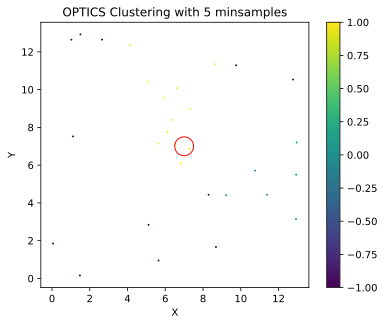

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


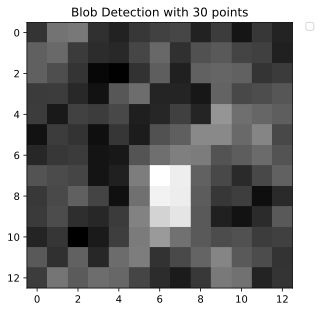

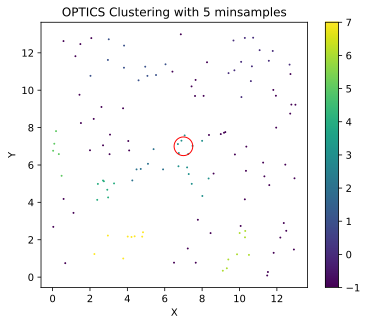

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


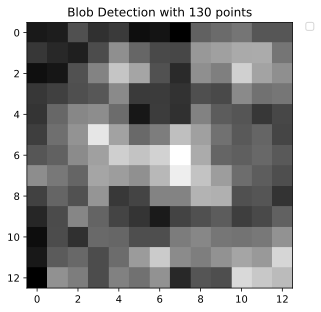

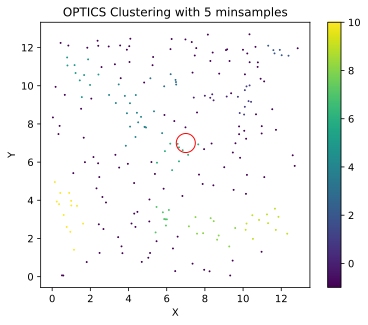

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


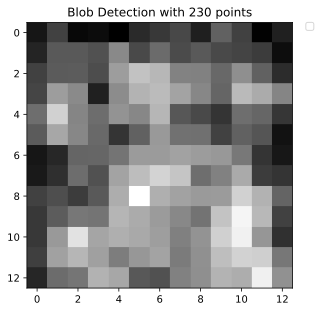

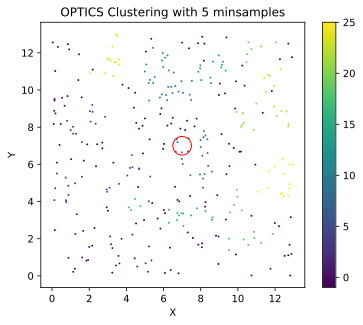

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyboardInterrupt: 

In [10]:
#point change
density_scan = np.linspace(5,100,1)
point_scan = np.arange(30,500,100)
num_blobs = np.zeros(len(point_scan))
num_clusters = np.zeros(len(point_scan))
error_min_cluster = np.zeros(len(point_scan)) -1
min_blob_error = np.zeros(len(point_scan)) -1
min_samples = 5
threshold_center = 0.5
for i in point_scan:
    sim = simulate_foci.sim_foci(max_x = 13,
                            min_x = 0,
                            radius = 0.5,
                            center = [7.,7.],
                            total_points = i,
                            density_dif = 5.0,
                            pdf = simulate_foci.tophat_function_2d,
                            point_intensity = 40,
                            projection_frames = 1000)
    sim.uniform_blob = False
    sim.psf_sigma = 0.82
    sim.base_noise = 140
    map,sim_xy = sim.simulate_point(generator = None,movie=False)

    clustering = OPTICS(min_samples=min_samples).fit(sim_xy)
    fig,ax = plt.subplots()
    a = ax.scatter(sim_xy[:,0],sim_xy[:,1],s= 1,c = clustering.labels_)
    #make a circle for the simulated blob
    cir = plt.Circle((sim.center[0],sim.center[1]),sim.radius,fill = False,edgecolor = "Red")
    ax.add_artist(cir)
    ax.set_aspect("equal")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("OPTICS Clustering with {} minsamples".format(min_samples))
    #add a colorbar
    fig.colorbar(a)
    plt.show()




    num_cluster = len(clustering.cluster_hierarchy_) -1
    num_clusters[np.where(point_scan == i)] = num_cluster

    min_error = np.inf
    #for each cluster use the smallest enclosing circle to find the radius of the cluster
    for kk in np.unique(clustering.labels_):
        #find the points in the cluster
        cluster_points = sim_xy[np.where(clustering.labels_ == kk)]
        #find the smallest enclosing circle
        center_x,center_y,radius = smallestenclosingcircle.make_circle(cluster_points)
        #find the error
        #check if the center is close to the simulated center of threshold: threshold_center
        if np.abs(center_x - sim.center[0]) < threshold_center and np.abs(center_y - sim.center[1]) < threshold_center:
            if np.abs(radius - sim.radius)/sim.radius < min_error:
                min_error = np.abs(radius - sim.radius)/sim.radius
    # if min_error == 10:
    #     min_error = -1
    error_min_cluster[np.where(point_scan == i)] = min_error
        

    



    b = blob_detection(path = map,\
                    median= False,\
                    threshold= 1e3, \
                    min_sigma= 1/np.sqrt(2), \
                    max_sigma = 10/np.sqrt(2), \
                    num_sigma= 1000, \
                    overlap = 0, \
                    logscale=False,
                    verbose=True)
    b._update_fitting_parameters(kwargs={"mask_size":3,
                                "plot_fit":False,
                                "fitting_image":"Original",
                                "radius_func":None,
                                "sigma_range":2,
                                "centroid_range":2})
    c = b.detection(type = "bp")
    #find the number of blobs identified
    num_blob = len(c["Scale"])
    num_blobs[np.where(point_scan == i)] = num_blob
    #find the size of the blob identified
    blob_size = c["Scale"][:,2]
    #comapre the blob size to the simulated one using a square error
    try:
        error_blob_size = np.min(np.abs(blob_size - sim.radius))/sim.radius
        #make sure that the blob that produced this min error is the one that is closest to the simulated blob with threshold: threshold_center
        #find the index of the blob that is closest to the simulated blob
        index = np.argmin(np.abs(blob_size - sim.radius))
        #find the center of the blob
        center = c["Scale"][index,0:2]
        print(center)
        #find the distance between the center of the blob and the simulated blob
        distance = np.sqrt(np.sum((center - sim.center)**2))
        #if the distance is greater than the threshold then the blob is not the correct one and the error is set to -1
        if distance > threshold_center:
            error_blob_size = np.inf

    except:
        error_blob_size = np.inf
    min_blob_error[np.where(point_scan == i)] = error_blob_size


    #plot the map with the identified blobs
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(map,cmap="gray")
    for j in c["Scale"]:
        cir = plt.Circle((j[1],j[0]),j[2],fill = False, edgecolor = "green")
        ax.add_artist(cir)
        ax.plot(j[1],j[0],"o",color = "green",markersize = 2,label = "Fitted Blob Center and Radius")
        cir2 = plt.Circle((sim.center[0],sim.center[1]),sim.radius,fill = False,edgecolor = "Red")
        ax.add_artist(cir2)
        ax.plot(sim.center[0],sim.center[1],"o",color = "red",markersize = 2,label = "Simulated Blob Center and Radius")
    #add a legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title("Blob Detection with {} points".format(i))
    plt.show()


#create a plot with two y axis ( one for num_blobs and one for num_clusters)
fig,ax1 = plt.subplots()
ax1.plot(point_scan,num_blobs,"o",label = "Number of Blobs")
ax1.set_xlabel("Number of Points")
ax1.set_ylabel("Number of Blobs")
ax1.set_title("Number of Blobs vs Number of Points")
ax2 = ax1.twinx()
ax2.plot(point_scan,num_clusters,"o",color = "red",label = "Number of Clusters")
ax2.set_ylabel("Number of Clusters")
ax2.legend()
plt.show()

#make a new plot with both plots on the same axis
fig,ax1 = plt.subplots()
ax1.plot(point_scan,num_blobs,"o",label = "Number of Blobs")
ax1.set_xlabel("Number of Points")
ax1.set_ylabel("Number of Blobs")
ax1.set_title("Number of Blobs vs Number of Points")
ax1.plot(point_scan,num_clusters,"o",color = "red",label = "Number of Clusters")
ax1.legend()
plt.show()


#plot the error in the blob size
fig,ax = plt.subplots()
ax.plot(point_scan,min_blob_error,"o")
ax.set_xlabel("Number of Points")
ax.set_ylabel("Error in Blob Size")
ax.set_title("Error in Blob Size vs Number of Points")
plt.show()

#plot the error in the cluster size
fig,ax = plt.subplots()
ax.plot(point_scan,error_min_cluster,"o")
ax.set_xlabel("Number of Points")
ax.set_ylabel("Error in Cluster Size")
ax.set_title("Error in Cluster Size vs Number of Points")
plt.show()


    

OPTIC+BLOB

In [ ]:
#density change
save_dir = "/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter 2/density_change"


density_scan = np.linspace(1,30,10)
point_scan = np.arange(10,1000,100)
num_blobs = np.zeros(len(density_scan))
num_clusters = np.zeros(len(density_scan))
for i in density_scan:
    sim = simulate_foci.sim_foci(max_x = 15,
                            min_x = 0,
                            radius = 2,
                            center = [7.,7.],
                            total_points = 300,
                            density_dif = i,
                            pdf = simulate_foci.tophat_function_2d,
                            point_intensity = 40,
                            projection_frames = 1000)
    sim.uniform_blob = False
    sim.psf_sigma = 0.82
    sim.base_noise = 140
    map,sim_xy = sim.simulate_point(generator = None,movie=False)
    fig,ax = plt.subplots()
    ax.plot(sim_xy[:,0],sim_xy[:,1],".")
    ax.set_aspect("equal")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Simulated Points Locations for {} density diff".format(i))
    #save the figure
    plt.savefig(os.path.join(save_dir,"simulated_points_{}_Density_diff.png".format(i)))
    plt.show()

    clustering = OPTICS(min_samples=30).fit(sim_xy)
    a = plt.scatter(sim_xy[:,0],sim_xy[:,1],s= 1,c = clustering.labels_)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("OPTICS Clustering with {} minsamples".format(30))
    #add a colorbar
    plt.colorbar(a)
    #save the figure
    plt.savefig(os.path.join(save_dir,"OPTICS_Clustering_{}_Density_diff.png".format(i)))
    plt.show()

    num_cluster = len(clustering.cluster_hierarchy_)
    num_clusters[np.where(density_scan == i)] = num_cluster
    b = blob_detection(path = map,\
                    median= False,\
                    threshold= 6e2, \
                    min_sigma= 1.4/np.sqrt(2), \
                    max_sigma = 10/np.sqrt(2), \
                    num_sigma= 1000, \
                    overlap = 0, \
                    logscale=False,
                    verbose=True)
    b._update_fitting_parameters(kwargs={"mask_size":3,
                                "plot_fit":False,
                                "fitting_image":"Original",
                                "radius_func":None,
                                "sigma_range":2,
                                "centroid_range":2})
    c = b.detection(type = "bp")
    #find the number of blobs identified
    num_blob = len(c["Scale"])
    num_blobs[np.where(density_scan == i)] = num_blob
    #find the size of the blob identified
    blob_size = np.mean(c["Scale"][:,2])
    #comapre the blob size to the simulated one
    error_blob_size = np.abs(blob_size - sim.radius)/sim.radius
    #plot the map with the identified blobs
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(map,cmap="gray")
    for j in c["Scale"]:
        cir = plt.Circle((j[1],j[0]),j[2],fill = False, edgecolor = "green")
        ax.add_artist(cir)
        ax.plot(j[1],j[0],"o",color = "green",markersize = 2,label = "Fitted Blob Center and Radius")
    cir2 = plt.Circle((sim.center[0],sim.center[1]),sim.radius,fill = False,edgecolor = "Red")
    ax.add_artist(cir2)
    ax.plot(sim.center[0],sim.center[1],"o",color = "red",markersize = 2,label = "Simulated Blob Center and Radius")
    #add a legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title("Blob Detection with {} density".format(i))
    #save the figure
    plt.savefig(os.path.join(save_dir,"blob_detection_{}_density_diff.png".format(i)))
    plt.show()

#create a plot with two y axis ( one for num_blobs and one for num_clusters)
fig,ax1 = plt.subplots()
ax1.plot(density_scan,num_blobs,"o",label = "Number of Blobs")
ax1.set_xlabel("Number of Points")
ax1.set_ylabel("Number of Blobs")
ax1.set_title("Number of Blobs vs Number of Points")
ax2 = ax1.twinx()
ax2.plot(density_scan,num_clusters,"o",color = "red",label = "Number of Clusters")
ax2.set_ylabel("Number of Clusters")
ax2.legend()
#save the figure
plt.savefig(os.path.join(save_dir,"num_blobs_num_clusters_density_diff.png"))
plt.show()



PSF change

In [ ]:
#psf change 
saving_dir = '/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter 2/psf_change_blob_OPTIC_Detection'
density_scan = np.linspace(1,100,10)
point_scan = np.arange(10,1000,100)
psf_scan = np.linspace(0.1,5,20)
num_blobs = np.zeros(len(psf_scan))
num_clusters = np.zeros(len(psf_scan))
for i in psf_scan:
    sim = simulate_foci.sim_foci(max_x = 50,
                            min_x = 0,
                            radius = 2,
                            center = [20.,25.],
                            total_points = 1000,
                            density_dif = 20.0,
                            pdf = simulate_foci.tophat_function_2d,
                            point_intensity = 40,
                            projection_frames = 1000)
    sim.uniform_blob = False
    sim.psf_sigma = i
    sim.base_noise = 140
    map,sim_xy = sim.simulate_point(generator = None,movie=False)
    fig,ax = plt.subplots()
    ax.plot(sim_xy[:,0],sim_xy[:,1],".")
    ax.set_aspect("equal")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Simulated Points Locations {} psf_sigma".format(i*130))
    #save the figure
    plt.savefig(os.path.join(saving_dir,"Simulated Points Locations {} psf_sigma.png".format(i*130)))
    plt.show()

    clustering = OPTICS(min_samples=30).fit(sim_xy)
    a = plt.scatter(sim_xy[:,0],sim_xy[:,1],s= 1,c = clustering.labels_)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("OPTICS Clustering with {} minsamples".format(30))
    #add a colorbar
    plt.colorbar(a)
    plt.savefig(os.path.join(saving_dir,"OPTICS Clustering with {} minsamples.png".format(30)))
    plt.show()

    num_cluster = len(clustering.cluster_hierarchy_)
    num_clusters[np.where(psf_scan == i)] = num_cluster
    b = blob_detection(path = map,\
                    median= False,\
                    threshold= 1e3, \
                    min_sigma= 1.4/np.sqrt(2), \
                    max_sigma = 10/np.sqrt(2), \
                    num_sigma= 1000, \
                    overlap = 0, \
                    logscale=False,
                    verbose=True)
    b._update_fitting_parameters(kwargs={"mask_size":3,
                                "plot_fit":False,
                                "fitting_image":"Original",
                                "radius_func":None,
                                "sigma_range":2,
                                "centroid_range":2})
    c = b.detection(type = "bp")
    #find the number of blobs identified
    num_blob = len(c["Scale"])
    num_blobs[np.where(psf_scan == i)] = num_blob
    #find the size of the blob identified
    blob_size = np.mean(c["Scale"][:,2])
    #comapre the blob size to the simulated one
    error_blob_size = np.abs(blob_size - sim.radius)/sim.radius
    #plot the map with the identified blobs
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(map,cmap="gray")
    for j in c["Scale"]:
        cir = plt.Circle((j[1],j[0]),j[2],fill = False, edgecolor = "green")
        ax.add_artist(cir)
        ax.plot(j[1],j[0],"o",color = "green",markersize = 2,label = "Fitted Blob Center and Radius")
        
    cir2 = plt.Circle((sim.center[0],sim.center[1]),sim.radius,fill = False,edgecolor = "Red")
    ax.add_artist(cir2)
    ax.plot(sim.center[0],sim.center[1],"o",color = "red",markersize = 2,label = "Simulated Blob Center and Radius")
    #add a legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title("Blob Detection with {} psf_sigma".format(i*130))
    plt.savefig(os.path.join(saving_dir,"Blob Detection with {} psf_sigma.png".format(i*130)))
    plt.show()

#create a plot with two y axis ( one for num_blobs and one for num_clusters)
fig,ax1 = plt.subplots()
ax1.plot(psf_scan*130,num_blobs,"o",label = "Number of Blobs")
ax1.set_xlabel("psf sigma (nm)")
ax1.set_ylabel("Number of Blobs")
ax1.set_title("Number of Blobs vs Number of Points")
ax2 = ax1.twinx()
ax2.plot(psf_scan*130,num_clusters,"o",color = "red",label = "Number of Clusters")
ax2.set_ylabel("Number of Clusters")
#plot a line at y = 1 to show the number of clusters
ax1.axhline(y=1, color='g', linestyle='--')
fig.legend(loc="upper right")
plt.savefig(os.path.join(saving_dir,"Number of Blobs vs Number of Points.png"))
plt.show()

Radius Change

In [ ]:
#radius change 
save_dir = "/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter 2/Radius_change_single"
density_scan = np.linspace(1,100,10)
point_scan = np.arange(10,1000,100)
psf_scan = np.linspace(0.1,5,20)
radius_scan = np.linspace(0.5,6,10)
num_blobs = np.zeros(len(radius_scan))
num_clusters = np.zeros(len(radius_scan))
min_samples = 50


for i in radius_scan:
    sim = simulate_foci.sim_foci(max_x = 15,
                            min_x = 0,
                            radius = i,
                            center = [7.5,7.5],
                            total_points = 300,
                            density_dif = 7.0,
                            pdf = simulate_foci.tophat_function_2d,
                            point_intensity = 40,
                            projection_frames = 1000)
    sim.uniform_blob = False
    sim.psf_sigma = 0.82
    sim.base_noise = 140
    map,sim_xy = sim.simulate_point(generator = None,movie=False)
    fig,ax = plt.subplots()
    ax.plot(sim_xy[:,0],sim_xy[:,1],".")
    ax.set_aspect("equal")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Simulated Points Locations {} radius (nm)".format(i*130))
    plt.savefig(os.path.join(save_dir,"Simulated Points Locations {} radius.png".format(i)))
    plt.show()

    clustering = OPTICS(min_samples=min_samples).fit(sim_xy)
    a = plt.scatter(sim_xy[:,0],sim_xy[:,1],s= 1,c = clustering.labels_)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("OPTICS Clustering with {} minsamples".format(min_samples))
    plt.savefig(os.path.join(save_dir,"OPTICS Clustering with {} minsamples.png".format(min_samples)))
    #add a colorbar
    plt.colorbar(a)
    plt.show()

    num_cluster = len(clustering.cluster_hierarchy_)
    num_clusters[np.where(radius_scan == i)] = num_cluster
    b = blob_detection(path = map,\
                    median= False,\
                    threshold= 1e3, \
                    min_sigma= 1.1/np.sqrt(2), \
                    max_sigma = 10/np.sqrt(2), \
                    num_sigma= 1000, \
                    overlap = 0, \
                    logscale=False,
                    verbose=True)
    b._update_fitting_parameters(kwargs={"mask_size":3,
                                "plot_fit":False,
                                "fitting_image":"Original",
                                "radius_func":None,
                                "sigma_range":2,
                                "centroid_range":2})
    c = b.detection(type = "bp")
    #find the number of blobs identified
    num_blob = len(c["Scale"])
    num_blobs[np.where(radius_scan == i)] = num_blob
    #find the size of the blob identified
    blob_size = np.mean(c["Scale"][:,2])
    #comapre the blob size to the simulated one
    error_blob_size = np.abs(blob_size - sim.radius)/sim.radius
    #plot the map with the identified blobs
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(map,cmap="gray")
    for j in range(len(c["Scale"])):
        cir = plt.Circle((c["Fitted"][j][1],c["Fitted"][j][0]),c["Scale"][j][2],fill = False, edgecolor = "green")
        ax.add_artist(cir)
        ax.plot(c["Fitted"][j][1],c["Fitted"][j][0],"o",color = "green",markersize = 2,label = "Fitted Blob Center and Radius")
        
    cir2 = plt.Circle((sim.center[0],sim.center[1]),sim.radius,fill = False,edgecolor = "Red")
    ax.add_artist(cir2)
    ax.plot(sim.center[0],sim.center[1],"o",color = "red",markersize = 2,label = "Simulated Blob Center and Radius")
    #add a legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title("Blob Detection with {} radius (nm)".format(i*130))
    plt.savefig(os.path.join(save_dir,"Blob Detection with {} radius.png".format(i)))
    plt.show()

#create a plot with two y axis ( one for num_blobs and one for num_clusters)
fig,ax1 = plt.subplots()
ax1.plot(radius_scan,num_blobs,"o",label = "Number of Blobs")
ax1.set_xlabel("radius")
ax1.set_ylabel("Number of Blobs")
ax1.set_title("Number of Blobs vs Size of Condensate")
ax2 = ax1.twinx()
ax2.plot(radius_scan,num_clusters,"o",color = "red",label = "Number of Clusters")
ax2.set_ylabel("Number of Clusters")
#plot a line at y = 1 to show the number of clusters
ax1.axhline(y=1, color='g', linestyle='--')
fig.legend(loc="upper right")
plt.savefig(os.path.join(save_dir,"Number of Blobs vs Number of Points.png"))
plt.show()

POINT + Density Change

In [ ]:
#point and density change
density_scan = np.linspace(1,100,10)
point_scan = np.arange(10,1000,100)
psf_scan = np.linspace(0.1,5,20)
num_blobs = np.zeros((len(density_scan),len(point_scan)))
num_clusters = np.zeros((len(density_scan),len(point_scan)))
min_blob_error = np.zeros((len(density_scan),len(point_scan)))

repeats = 10


for i in range(len(density_scan)):
    for k in range(len(point_scan)):
        mean_num_blob = 0
        mean_num_cluster = 0
        mean_min_blob_error = 0

        for l in range(repeats):
            sim = simulate_foci.sim_foci(max_x = 50,
                                    min_x = 0,
                                    radius = 2,
                                    center = [20.,25.],
                                    total_points = point_scan[k],
                                    density_dif = density_scan[i],
                                    pdf = simulate_foci.tophat_function_2d,
                                    point_intensity = 40,
                                    projection_frames = 1000)
            sim.uniform_blob = False
            sim.psf_sigma = 0.82
            sim.base_noise = 140
            map,sim_xy = sim.simulate_point(generator = None,movie=False)
            # fig,ax = plt.subplots()
            # ax.plot(sim_xy[:,0],sim_xy[:,1],".")
            # ax.set_aspect("equal")
            # ax.set_xlabel("X")
            # ax.set_ylabel("Y")
            # ax.set_title("Simulated Points Locations {} psf_sigma".format(i*130))
            # plt.show()

            clustering = OPTICS(min_samples=5).fit(sim_xy)
            # a = plt.scatter(sim_xy[:,0],sim_xy[:,1],s= 1,c = clustering.labels_)
            # plt.xlabel("X")
            # plt.ylabel("Y")
            # plt.title("OPTICS Clustering with {} minsamples".format(5))
            # #add a colorbar
            # plt.colorbar(a)
            # plt.show()

            num_cluster = len(clustering.cluster_hierarchy_)
            mean_num_cluster += num_cluster
            b = blob_detection(path = map,\
                            median= False,\
                            threshold= 6e2, \
                            min_sigma= 1.4/np.sqrt(2), \
                            max_sigma = 10/np.sqrt(2), \
                            num_sigma= 1000, \
                            overlap = 0, \
                            logscale=False,
                            verbose=True)
            b._update_fitting_parameters(kwargs={"mask_size":3,
                                        "plot_fit":False,
                                        "fitting_image":"Original",
                                        "radius_func":None,
                                        "sigma_range":2,
                                        "centroid_range":2})
            c = b.detection(type = "bp")
            #find the number of blobs identified
            num_blob = len(c["Scale"])
            mean_num_blob += num_blob
            #find the size of the blob identified
            blob_size = c["Scale"][:,2]
            #comapre the blob size to the simulated one using a square error
            try:
                error_blob_size = np.min(np.abs(blob_size - sim.radius))/sim.radius
            except:
                error_blob_size = -1
            mean_min_blob_error += error_blob_size
            #plot the map with the identified blobs
            # fig = plt.figure()
            # ax = fig.add_subplot()
            # ax.imshow(map,cmap="gray")
            # for j in c["Scale"]:
            #     cir = plt.Circle((j[1],j[0]),j[2],fill = False, edgecolor = "green")
            #     ax.add_artist(cir)
            #     ax.plot(j[1],j[0],"o",color = "green",markersize = 2,label = "Fitted Blob Center and Radius")
                
            # cir2 = plt.Circle((sim.center[0],sim.center[1]),sim.radius,fill = False,edgecolor = "Red")
            # ax.add_artist(cir2)
            # ax.plot(sim.center[0],sim.center[1],"o",color = "red",markersize = 2,label = "Simulated Blob Center and Radius")
            # #add a legend outside the plot
            # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            # plt.title("Blob Detection with {} psf_sigma".format(i*130))
            # plt.show()
        num_blobs[i,k] = mean_num_blob/repeats
        num_clusters[i,k] = mean_num_cluster/repeats
        min_blob_error[i,k] = mean_min_blob_error/repeats
        


In [ ]:
#plot the number of blobs and clusters as a function of density and number of points in a 3d plot
xv, yv = np.meshgrid(density_scan, point_scan)
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
a1 = ax.plot_surface(xv.T,yv.T,num_blobs,cmap=cm.coolwarm)
ax.set_xlabel("Density")
ax.set_ylabel("Number of Points")
ax.set_zlabel("Number of Blobs")
plt.title("Number of Blobs vs Density and Number of Points")
fig.colorbar(a1,shrink=0.5, aspect=5)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
a2 = ax.plot_surface(xv.T,yv.T,num_clusters,cmap=cm.coolwarm)
ax.set_xlabel("Density")
ax.set_ylabel("Number of Points")
ax.set_zlabel("Number of Clusters")
plt.title("Number of Clusters vs Density and Number of Points")
fig.colorbar(a2,shrink=0.5, aspect=5)
plt.show()

#plot the error in blob size as a function of density and number of points in a 3d plot
#relace all np.nan with -1
min_blob_error[np.isnan(min_blob_error)] = -1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
a3 = ax.plot_surface(xv.T,yv.T,min_blob_error,cmap=cm.coolwarm)
ax.set_xlabel("Density")
ax.set_ylabel("Number of Points")
ax.set_zlabel("Error in Blob Size")
plt.title("Error in Blob Size vs Density and Number of Points")
fig.colorbar(a3,shrink=0.5, aspect=5)
plt.show()

dict = {"doc": "There is 2 independent parameters 1) point_scan, 2) density_scan \n and 3 dependent parameters 1) num_blobs, 2) num_clusters, 3) min_blob_error.",
        "point_scan":point_scan,
        "density_scan":density_scan,
        "num_blobs":num_blobs,
        "num_clusters":num_clusters,
        "min_blob_error":min_blob_error}

#save the dictionary as a pickle file
with open("/Users/baljyot/Documents/2022-2023/PhD_Thesis/pickled_data/num_blobs_clusters.pkl","wb") as f:
        pickle.dump(dict,f)

    

